# Calling genotypes, prevalences and filtering data
This program analyzes tables of counts. In the prior "variant calling" step of the program, mutation counts were generated for each sample by annotating the VCF file generated by freebayes, using SNPEff to assign amino acid names to mutations.

The count tables are intended to be as "raw" as possible. In this part of the analysis we will:
1. apply various filters to the count tables, considering a mutation 'sampled' for a sample if it passes the filters for that sample.
2. choose the level of detail of geographic locations we care about from a metadata file
3. summarize the number of filtered samples at each location that had the mutation and the total number of filtered samples at each location, where the 'prevalence' of a mutation at a location is the first number divided by the second number
4. graph the prevalences and filtered sample sizes on a map
5. (optional) - apply additional filtering for re-evaluation of prevalence data.

In [4]:
# RUN
import sys
sys.path.append("/opt/src")
import calculate_prevalences as cap
import os
import pandas as pd
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
wdir = "/opt/user/stats_and_variant_calling/"
import ipywidgets as widgets
import yaml

In [5]:
# RUN

mutation_count_file = "alternate_AA_table.csv"
mutation_coverage_file = "coverage_AA_table.csv"

In [6]:
# RUN
import pandas as pd
mutation_counts = pd.read_csv(mutation_count_file,
                              header=list(range(6)),
                              index_col=0)
mutation_coverage = pd.read_csv(mutation_coverage_file,
                                index_col=0,
                                header=list(range(6)))

metadata_table=pd.read_csv('/opt/user/prevalence_metadata/metadata.csv')

mutation_handle=open(mutation_count_file)
mutation_handle.readline()
mutation_handle.readline()
mutations=mutation_handle.readline().strip().split(',')
filtered_mutations=[]
for mutation in mutations[1:]:
    change=mutation.split('-')[-1]
    if 'ins' not in change and 'del' not in change and 'dup' not in change:
        filtered_mutations.append(mutation)
print('observed mutations are:\n\n')
print(filtered_mutations)
print('\n\nmetadata table is')
metadata_table.head()

observed mutations are:


['Pfubp1-Asn157Lys', 'Pfubp1-Asn339Asp', 'atp6-Ala623Glu', 'atp6-Glu431Lys', 'atp6-Leu402Val', 'atp6-Ser769Asn', 'PF3D7-0218600-Asn63Asp', 'PF3D7-0218600-Ile638Met', 'PF3D7-0218600-Lys438fs', 'PF3D7-0218600-Met439fs', 'PF3D7-0218600-Met632Ile', 'dhfr-ts-Ala16Val', 'dhfr-ts-Asn51Ile', 'dhfr-ts-Cys59Arg', 'dhfr-ts-Ile164Leu', 'dhfr-ts-Ser108Asn', 'dhfr-ts-Ser108Thr', 'PI4K-Asn957His', 'PI4K-Ser915Gly', 'mdr1-Ala317Ser', 'mdr1-Ala750Glu', 'mdr1-Ala821Ser', 'mdr1-Arg54Lys', 'mdr1-Arg614Lys', 'mdr1-Arg640Lys', 'mdr1-Arg640Thr', 'mdr1-Asn1042Asp', 'mdr1-Asn1106Tyr', 'mdr1-Asn1120His', 'mdr1-Asn1193Ser', 'mdr1-Asn1202Ile', 'mdr1-Asn1203Ser', 'mdr1-Asn1227Tyr', 'mdr1-Asn12Ser', 'mdr1-Asn12Thr', 'mdr1-Asn255Lys', 'mdr1-Asn473Ser', 'mdr1-Asn497Asp', 'mdr1-Asn504Lys', 'mdr1-Asn649Asp', 'mdr1-Asn652Asp', 'mdr1-Asn653Asp', 'mdr1-Asn704Lys', 'mdr1-Asn849Ser', 'mdr1-Asn86Phe', 'mdr1-Asn86Tyr', 'mdr1-Asp1196Tyr', 'mdr1-Asp1246Tyr', 'mdr1-Asp367His', 'mdr1-Asp388Gly', 'mdr1-As

,Sample_ID,Collection_year,Region,Region_code,District,District_code,HF_name,HF_code,Latitude,Longitude,RDT_result,iso3c,site_study_type,wrangled_sample_name
0,LUN-5211004-2021-MSMT-1,2021,Ruvuma,RV,Nyasa,NY,Lundo,LUN,-11.16288,34.73973,POS,TZA,community,LUN-5211004-2021-MSMT-1
1,LUN-5211008-2021-MSMT-1,2021,Ruvuma,RV,Nyasa,NY,Lundo,LUN,-11.16288,34.73973,POS,TZA,community,LUN-5211008-2021-MSMT-1
2,LUN-5211009-2021-MSMT-1,2021,Ruvuma,RV,Nyasa,NY,Lundo,LUN,-11.16288,34.73973,POS,TZA,community,LUN-5211009-2021-MSMT-1
3,LUN-5211011-2021-MSMT-1,2021,Ruvuma,RV,Nyasa,NY,Lundo,LUN,-11.16288,34.73973,POS,TZA,community,LUN-5211011-2021-MSMT-1
4,LUN-5211018-2021-MSMT-1,2021,Ruvuma,RV,Nyasa,NY,Lundo,LUN,-11.16288,34.73973,POS,TZA,community,LUN-5211018-2021-MSMT-1


In [7]:
# USER INPUT

# how many reads (or, more accurately, UMIs) do we need spanning the genomic coordinates of a mutation in order to
# consider the coordinates "sequenced" for a given sample? If UMI count is below min_coverage, the sample will be
# marked as "missing" for the mutation of interest.
min_coverage = 10

# If min_coverage is achieved in the sample, how many UMIs do we need that support the mutant (or alternate) allele
# in order to consider the alternate allele "present" in the sample? Otherwise if min_coverage is surpassed but
# min_count is not, the sample will be marked as matching the reference allele.
min_count = 3

# Is there a number that min_count/min_coverage needs to surpass before we consider an alternate allele "present" in a
# sample? Our usual answer is 'no' so we generally set this to '0' - but you may not want to count an alternate allele
# present if it's found in a very low fraction of the UMIs associated with a sample, even if the absolute number of UMIs
# associated with the alternate allele is above your threshold.
min_freq = 0

# Which mutations would you like to graph? A full list of observed mutations is created when you run the code in the
# cell above.
mutations_of_interest=[
'dhfr-ts-Asn51Ile', 'dhfr-ts-Cys59Arg', 'dhfr-ts-Ser108Asn', 'dhfr-ts-Ile164Leu',
'mdr1-Asn652Asp', 'mdr1-Asn86Tyr', 'mdr1-Asp1246Tyr', 'mdr1-Asp650Asn',
'mdr1-Tyr184Phe', 'crt-Met74Ile', 'crt-Asn75Glu', 'crt-Lys76Thr',
'crt-Gln271Glu', 'crt-Arg371Ile', 'dhps-Ala437Gly', 'dhps-Lys540Glu',
'dhps-Ala581Gly', 'k13-Lys108Glu', 'k13-His136Asn', 'k13-Lys189Asn',
'k13-Lys189Thr', 'k13-Arg255Lys', 'k13-Leu258Met', 'k13-Gln271His',
'k13-Cys469Phe', 'k13-Cys469Tyr', 'k13-Asn490Thr', 'k13-Arg561His',
'k13-Ala578Ser', 'k13-Ala675Val']

# In the metadata sheet (reproduced in the table output from the cell above), which column contains sample names and
# which column contains the names of the locations you'd like to plot (or summarize by)?
sample_column='Sample_ID'
summary_column='HF_name'

In [8]:
# Which country would you like to graph?
country_shortcuts={'DRC': 
                   {"lat": -1.6815695315287824,
                    "lon": 22.744896416745945,
                    'zoom': 3.8},
                   'Uganda': 
                   {"lat": 1.5,
                    'lon': 32,
                    'zoom': 4.8},
                   'Tanzania':
                   {"lat": -5.7,
                    "lon": 35,
                    'zoom': 5.2},
                  }

#you can specify a country to zoom in on from the list above
country='Tanzania'

country = widgets.Dropdown(
    options=country_shortcuts.keys(),
    description='Country:',
    disabled=False,
)
print("Country to zoom in and center the map on:\n")
display(country)



Country to zoom in and center the map on:



Dropdown(description='Country:', options=('DRC', 'Uganda', 'Tanzania'), value='DRC')

In [9]:
# RUN
country=country.value
zoom_level=country_shortcuts[country]['zoom']
latitude=country_shortcuts[country]['lat']
longitude=country_shortcuts[country]['lon']
# OPTIONAL USER INPUT:
# You can override the values above and set a custom zoom level and centering below by commenting these lines in
#zoom_level=4.8
#latitude=1.5
#longitude=32

In [10]:
# RUN

# import the PCA module which has genotype calling and
# filtering functions
import PCA

gt_calls = PCA.call_genotypes(mutation_counts, mutation_coverage,
                              min_count, min_coverage, min_freq)
#print('options are', gt_calls.keys())

# This step outputs samples that surpass the coverage threshold
# as their original coverage value and resets samples not passing the threshold as '0'.
# Note that even if there is insufficient coverage the resulting cell will be a '0' and not NaN
filtered_coverage=gt_calls["filtered_mutation_coverage"]
filtered_coverage.to_csv(os.path.join(wdir, "filtered_coverage_AA_table.csv"))

# This step outputs samples containing alternate alleles that surpass the coverage and alternate thresholds
# as their original values and samples not passing both thresholds as '0'. Note that even if there is insufficient
# coverage to make a call the output for this table will still be listed as '0'
filtered_mutation_counts = gt_calls["filtered_mutation_counts"]
filtered_mutation_counts.to_csv(os.path.join(
        wdir, "filtered_alternate_AA_table.csv"))

# This step outputs the within sample allele frequencies of each alternate allele. Unlike the tables above, this
# one displays NaN if the coverage levels do not surpass the threshold (due to dividing alternate counts by 0)
freq = gt_calls["wsaf"]
freq.to_csv(os.path.join(
        wdir, "within_sample_allele_frequencies.csv"))
freq.head()

# This step outputs a genotypes table, using the wsaf table as input. Cells can be NaN (coverage is below the
# threshold), 0 (frequency of the mutation is less than or equal to min_freq), 1 (frequency is bigger than min_freq but
# less than 100%) or 2 (mutation is found in all of the UMIs for the sample.
genotypes = gt_calls["genotypes"]
genotypes.to_csv(os.path.join(
        wdir, "filtered_genotypes_table.csv"))


# The outputs of this table are the same as the genotypes table, except this table does not differentiate between
# alternate alleles that are found in all UMIs of a sample and those that are found in some of the UMIs
# (both '2' and '1' values from the genotypes table get reset to '1')
prevalences_input = gt_calls["prevalences"]
prevalences_input.to_csv(os.path.join(wdir, "prevalences_input_table.csv"))


# To view the outputs of any given step, comment in the corresponding table below (or open the corresponding csv
# file in a spreadsheet):
# filtered_coverage.head()
# filtered_mutation_counts.head()
# genotypes.head()
# prevalences_input.head()

# Calculate Prevalence in Each Region

In [30]:
# RUN
# Intersects the variants of interest with the table header
# default sort will sort mutations by gene and then reference amino acid name - this sorter sorts by gene and
# then amino acid position
def special_sort(mutations):
    sorting_list=[]
    for mutation in mutations:
        gene='-'.join(mutation.split('-')[:-1])
        pos=int(mutation.split('-')[-1][3:-3])
        sorting_list.append([gene, pos, mutation])
    return [item[-1] for item in sorted(sorting_list)]

prevalences_input='prevalences_input_table.csv'
variant_set = set(open(prevalences_input).readlines()[2].strip().split(',')[1:])
mutations_of_interest_set = set(mutations_of_interest)
variants_of_interest = list(variant_set.intersection(mutations_of_interest_set))
variants_of_interest=special_sort(mutations_of_interest)
print(variants_of_interest)

['crt-Met74Ile', 'crt-Asn75Glu', 'crt-Lys76Thr', 'crt-Gln271Glu', 'crt-Arg371Ile', 'dhfr-ts-Asn51Ile', 'dhfr-ts-Cys59Arg', 'dhfr-ts-Ser108Asn', 'dhfr-ts-Ile164Leu', 'dhps-Ala437Gly', 'dhps-Lys540Glu', 'dhps-Ala581Gly', 'k13-Lys108Glu', 'k13-His136Asn', 'k13-Lys189Asn', 'k13-Lys189Thr', 'k13-Arg255Lys', 'k13-Leu258Met', 'k13-Gln271His', 'k13-Cys469Phe', 'k13-Cys469Tyr', 'k13-Asn490Thr', 'k13-Arg561His', 'k13-Ala578Ser', 'k13-Ala675Val', 'mdr1-Asn86Tyr', 'mdr1-Tyr184Phe', 'mdr1-Asp650Asn', 'mdr1-Asn652Asp', 'mdr1-Asp1246Tyr']


In [12]:
# RUN
# This block loads the config file to find the associated metadata for your sample set. It summarizes the dataset by
# the user-specified summary_column and counts the number of '1' and '0' values from the prevalences_input_table
# for each named location found in the summary column. e.g. if there are 5 regions in a country and we're summarizing
# by region, there will be 5 named locations in the output table, and we will count the number of 'covered' samples in
# each region for each mutation along with the number of samples with the alternate allele for each mutation. These
# values appear as numerators and denominators in the output table below. Coordinates are averaged across all samples
# that share the same named location in the metadata. All sample sets need to share a single metadata file - this is to
# avoid naming conflicts in column names between different sample sets.
config_file = open('/opt/config/config_v0.5.1.yaml')
config_dict = yaml.safe_load(config_file)

prevalences_input_table = 'prevalences_input_table.csv'

contents=os.listdir('/opt/user/prevalence_metadata')
print('contents are', contents)

# get the sample sets from the user defined config file
sample_sets = config_dict['sample_set'].split(',')
if '' in sample_sets:
    sample_sets.remove('')
sample_sets = [x.replace(' ','') for x in sample_sets]

#path to the metadata - this is currently hardcoded
metadata_file = '/opt/user/prevalence_metadata/metadata.csv'

# generate a prevalence table for each set of samples
output_summary_table = 'prevalence_summary.tsv'

#    metadata_file='merged_corrected_renamed_samples_metadata.csv'
cap.calculate_prevalences(metadata_file,
                          prevalences_input_table,
                          mutations_of_interest,
                          output_summary_table, sample_column, summary_column)
prevalences=pd.read_csv(output_summary_table,
                          header=list(range(1)),
                          index_col=0, sep='\t')
prevalences.head(10)

contents are ['2023_metadata.csv', '2021_metadata.csv', 'README.txt', 'metadata.csv', '2022_metadata.csv']


,Latitude,Longitude,dhfr-ts-Asn51Ile,dhfr-ts-Cys59Arg,dhfr-ts-Ile164Leu,dhfr-ts-Ser108Asn,mdr1-Asn652Asp,mdr1-Asn86Tyr,mdr1-Asp1246Tyr,mdr1-Asp650Asn,...,k13-Arg255Lys,k13-Arg561His,k13-Cys469Phe,k13-Cys469Tyr,k13-Gln271His,k13-His136Asn,k13-Leu258Met,k13-Lys108Glu,k13-Lys189Asn,k13-Lys189Thr
HF_name,,,,,,,,,,,,,,,,,,,,,
Bukangara,-1.719199,31.024272,1.0 (150/150),0.8667 (130/150),0.3624 (54/149),1.0 (149/149),0.021 (3/143),0 (0/131),0.0395 (6/152),0.021 (3/143),...,0.0483 (7/145),0.259 (36/139),0 (0/144),0 (0/144),0 (0/136),0.016 (2/125),0.0207 (3/145),0 (0/125),0.0075 (1/134),0.3657 (49/134)
Charambe,-6.923261,39.255531,1.0 (80/80),0.9875 (79/80),0 (0/78),1.0 (81/81),0.1111 (8/72),0 (0/72),0 (0/81),0.1389 (10/72),...,0 (0/80),0 (0/73),0 (0/73),0 (0/73),0 (0/75),0.0441 (3/68),0.0125 (1/80),0 (0/68),0.0725 (5/69),0.2029 (14/69)
Chitare,-1.899901,33.394061,1.0 (128/128),0.9297 (119/128),0.04 (5/125),1.0 (124/124),0.0351 (4/114),0 (0/120),0.031 (4/129),0.0351 (4/114),...,0.0242 (3/124),0 (0/120),0 (0/124),0 (0/124),0 (0/120),0 (0/113),0.0323 (4/124),0 (0/113),0.0348 (4/115),0.287 (33/115)
Chivu,-2.497572,30.598627,1.0 (76/76),0.8684 (66/76),0.1857 (13/70),1.0 (74/74),0 (0/50),0 (0/44),0.026 (2/77),0.02 (1/50),...,0.0159 (1/63),0.0161 (1/62),0 (0/59),0 (0/59),0 (0/52),0 (0/33),0 (0/63),0 (0/33),0 (0/42),0.0952 (4/42)
Hedaru,-4.508585,37.911094,1.0 (107/107),0.9907 (106/107),0 (0/106),1.0 (107/107),0.0808 (8/99),0 (0/101),0.0093 (1/108),0.0909 (9/99),...,0.0097 (1/103),0 (0/103),0 (0/104),0 (0/104),0 (0/102),0.0104 (1/96),0.0194 (2/103),0 (0/96),0 (0/96),0.1458 (14/96)
Igoweko,-4.747659,33.605461,0.9935 (154/155),0.9484 (147/155),0 (0/157),1.0 (155/155),0.0548 (8/146),0 (0/145),0.0696 (11/158),0.0548 (8/146),...,0.0067 (1/150),0 (0/149),0 (0/151),0 (0/151),0 (0/144),0.0076 (1/132),0.0333 (5/150),0 (0/132),0.0286 (4/140),0.1786 (25/140)
Izengabatogilwe,-5.262074,32.281595,1.0 (47/47),0.8936 (42/47),0.0208 (1/48),1.0 (47/47),0.0294 (1/34),0 (0/27),0 (0/52),0.0588 (2/34),...,0.0222 (1/45),0 (0/40),0 (0/41),0 (0/41),0 (0/35),0 (0/23),0 (0/45),0 (0/23),0 (0/31),0.3548 (11/31)
Kijungu,-5.400421,37.185551,1.0 (97/97),1.0 (97/97),0 (0/97),1.0 (97/97),0.0761 (7/92),0 (0/94),0 (0/99),0.0761 (7/92),...,0 (0/97),0 (0/97),0 (0/98),0 (0/98),0 (0/92),0 (0/76),0 (0/97),0 (0/76),0 (0/89),0.2247 (20/89)
Kisorya,-2.108531,33.219641,1.0 (93/93),0.9247 (86/93),0.0204 (2/98),1.0 (91/91),0.0541 (4/74),0 (0/77),0.0198 (2/101),0.0676 (5/74),...,0 (0/91),0 (0/86),0 (0/87),0 (0/87),0 (0/82),0 (0/69),0.033 (3/91),0 (0/70),0.0127 (1/79),0.1899 (15/79)


# Plot Scatter map

In [13]:
# RUN
import math
import numpy as np
def make_detail_graph(variant, summary_column):
    df = pd.read_csv("prevalence_summary.tsv", sep='\t')
    if variant in list(df)[3:]:
        df["prevalence"] = df[variant].str.split(" ").str[0].astype(float)
        #df["prevalence_percent"] = df["prevalence"]*100+1
        #df["prevalence_log"]=np.log2(df["prevalence_percent"])
        max_prevalence = max(df["prevalence"].to_list())
        df["sample_size"] = (
            df[variant].str.split("/").str[1].str.replace(")", "").astype(float)
        )
        df = df[df["sample_size"] > 0]
        # df = df[df["Dataset"] == int(dataset)]

        fig = px.scatter_map(
            df,
            lat="Latitude",
            lon="Longitude",
            #color="prevalence_log",
            color="prevalence",
            size="sample_size",
            size_max=50,
            # color_continuous_scale='cividis',
            range_color=(0, max_prevalence), # use this to make the most prevalent mutation "pop" as bright yellow
            #range_color=(0,7), #use this if on a log2 scale
            #range_color=(0,1), #use this to color everything on the same scale from 0 (0%) to 1 (100%)
            zoom=zoom_level,
            hover_name=summary_column,
            height=800,
            width=800,
            hover_data=["sample_size"],
            center={"lat": latitude, "lon": longitude},
        )
    fig.update_layout(
        mapbox=dict(
            layers=[
                dict(
                    sourcetype="geojson",
                    source={"type": "FeatureCollection", "features": []},
                    type="fill",
                    color="blue",
                    below="traces",
                    visible=False  # Hide the layer by default
                    )
    ]
    )
    )
    return fig

In [14]:
# RUN
variants_of_interest=open("prevalence_summary.tsv").readline().split('\t')[3:]
variant = widgets.Dropdown(
    options=variants_of_interest,
    description='variant:',
    disabled=False,
)
display(variant)

Dropdown(description='variant:', options=('dhfr-ts-Asn51Ile', 'dhfr-ts-Cys59Arg', 'dhfr-ts-Ile164Leu', 'dhfr-t…

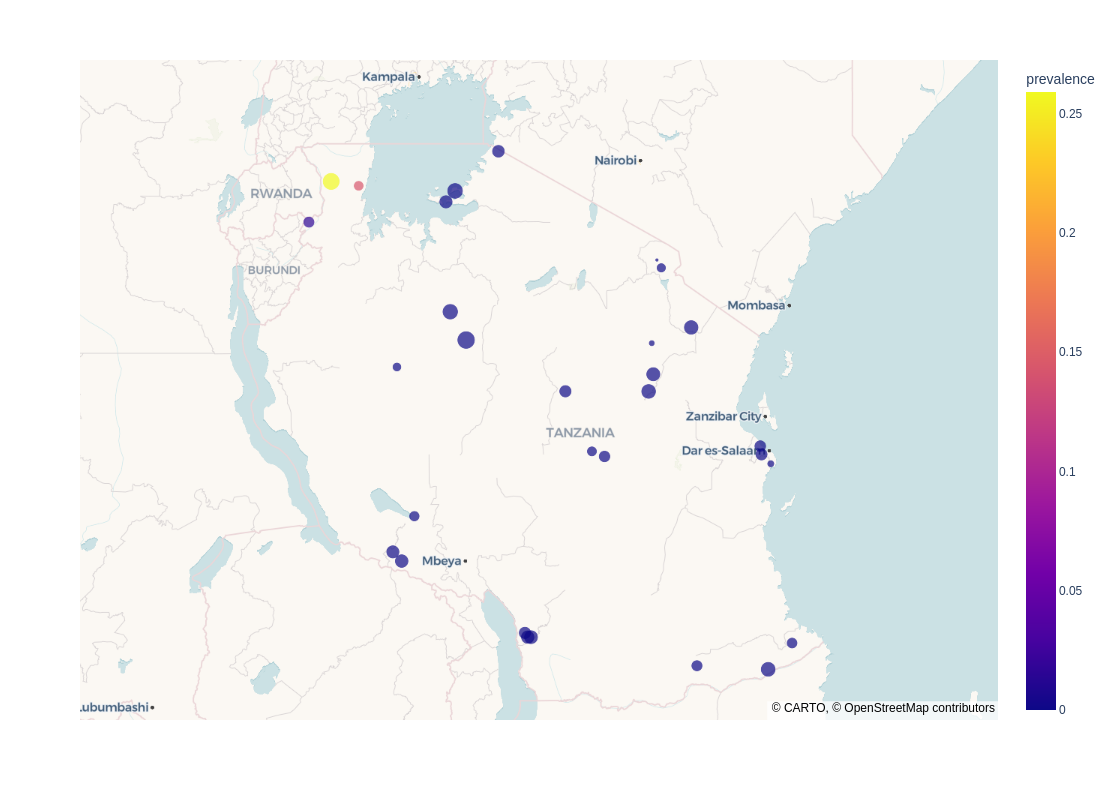

In [16]:
fig=make_detail_graph(variant.value, summary_column)
fig.show()
fig.write_image('first_plot.svg')
fig.write_image('first_plot.png')
fig.write_html('first_plot.html')

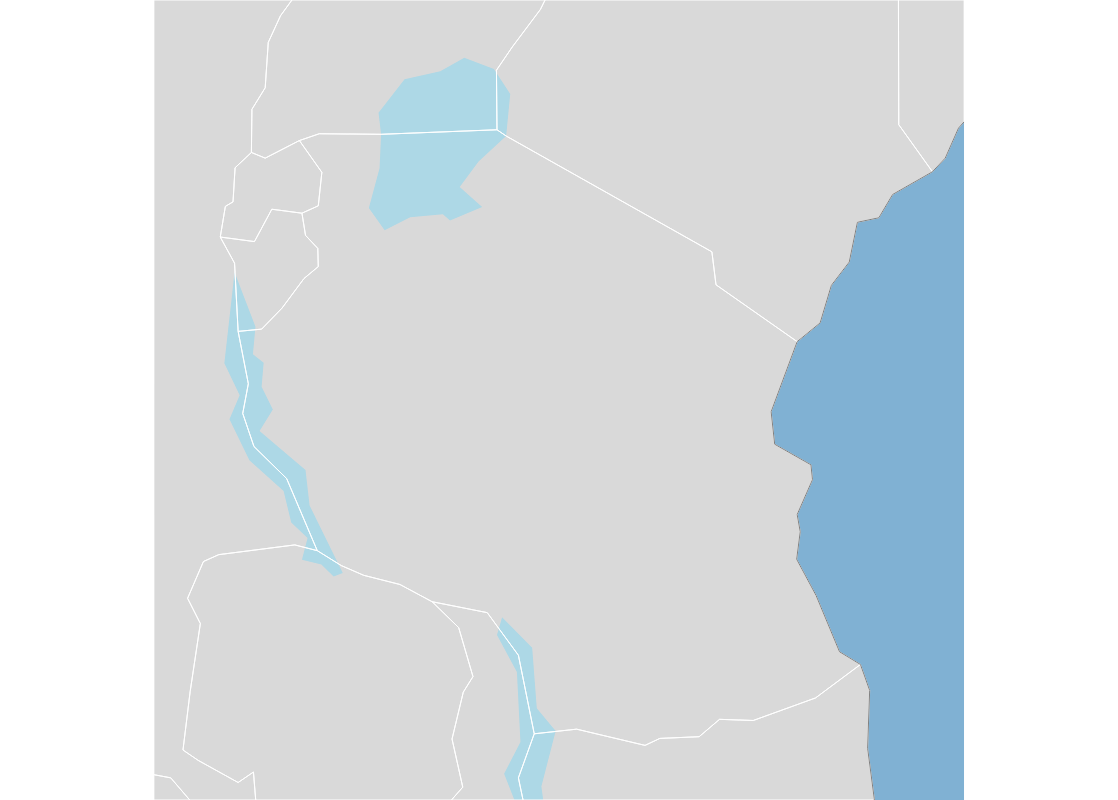

In [17]:
# Google AI suggested version (output below) - this version is required if you want to hide rivers, minor cities,
# major roads, district boundaries, etc. from the map - but this comes at the expense of loss of country labels.

# This code is still not fully implemented. If we went this route, we would need a box for user to manually add
# country names and GPS coordinates for each. A full implementation would also add a scale bar, country zoom dropdown
# menu, and colored dots like the ones above
import plotly.graph_objects as go

# Sample data - currently set to some arbitrary points in the US, easily reconfigurable
data = {'lat': [40.7128, 34.0522, 41.8781], 'lon': [-74.0060, -118.2437, -87.6298]}

fig = go.Figure(go.Scattergeo(
    lat=data['lat'],
    lon=data['lon'],
    mode='markers',
    marker=dict(size=10)
))

fig.update_layout(
    geo=dict(
        scope='africa',
        showland=True,
        landcolor='rgb(217, 217, 217)',
        showcountries=True,
        countrycolor='rgb(255, 255, 255)',
        showcoastlines=True,
        coastlinecolor='rgb(128, 128, 128)',
        showframe=False,  # Remove the outer frame
        showlakes=True,
        lakecolor='rgb(173, 216, 230)',
        showocean=True,
        oceancolor='rgb(128, 177, 211)',
        projection_type='mercator',  # Use a natural earth projection
    ),
    margin=dict(l=0, r=0, t=0, b=0)  # Remove margins
)

fig.update_layout(
    autosize=True,
    height=800,
    geo=dict(
        center=dict(
            lat=latitude,
            lon=longitude
        ),
        scope='africa',
        projection_scale=6.3
    )
)
fig.show()

In [43]:
# RUN
# This code generates a bar chart for your mutations of interest
def get_prevalences(prevalence_file, mutation_list):
	prevalence_dict={'mutations':[], 'prevalences':[], 'gene_name':[]}
	h_dict={}
	for line_number, line in enumerate(open(prevalence_file)):
		line=line.strip().split('\t')
		if line_number==0:
			for column_number, column in enumerate(line):
				h_dict[column]=column_number
		elif line[0]=='overall':
			for mutation in mutation_list:
				if mutation in h_dict:
					column=h_dict[mutation]
					prevalence=float(line[column].split(' ')[0])
					prevalence_dict['mutations'].append(mutation)
					prevalence_dict['prevalences'].append(prevalence)
					prevalence_dict['gene_name'].append(mutation.split('-')[0])
				else:
					print(mutation, f'is not found in {prevalence_file}!!')
	return prevalence_dict

def make_bar_chart(prevalence_dict, graph_type="bar chart of variants_of_interest", y_max=1.0):
	import pandas as pd
	import plotly.express as px
	df = pd.DataFrame(prevalence_dict)
	fig1=px.bar(df, x='mutations', y='prevalences', color='gene_name', text_auto=False)
	fig1['layout']['xaxis']['title']=graph_type
	fig1['layout']['yaxis']['title']='overall prevalence'
	fig1.update_layout(yaxis=dict(range=[0, y_max]))
	fig1.write_html(f'{graph_type}.html')
	fig1.write_image(f'{graph_type}.svg')
	fig1.write_image(f'{graph_type}.png')
	return fig1
chart_name='drug resistance mutations'
y_max=1.0

k13-Asn490Thr is not found in prevalence_summary.tsv!!


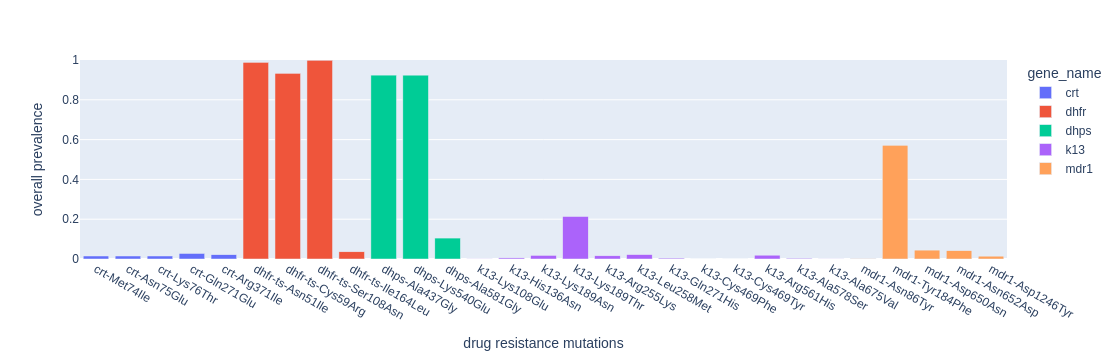

In [44]:
# OPTIONAL USER INPUT
# User can optionally reset the variants_of_interest to graph, chart_name, and y_max values (e.g. by commenting in one
#of the blocks of lines below), otherwise the values will be pulled from the cells above

#variants_of_interest=['crt-Met74Ile', 'crt-Asn75Glu', 'crt-Lys76Thr','crt-Gln271Glu',
#'crt-Arg371Ile', 'dhfr-ts-Asn51Ile', 'dhfr-ts-Cys59Arg', 'dhfr-ts-Ser108Asn',
#'dhfr-ts-Ile164Leu', 'dhps-Ala437Gly', 'dhps-Lys540Glu', 'dhps-Ala581Gly',
#'mdr1-Asn86Tyr', 'mdr1-Tyr184Phe', 'mdr1-Asp650Asn', 'mdr1-Asn652Asp',
#'mdr1-Asp1246Tyr']
#chart_name='non-k13 mutations'
#y_max=1.0

#variants_of_interest=['k13-Lys108Glu', 'k13-His136Asn', 'k13-Lys189Asn', 'k13-Lys189Thr',
#'k13-Arg255Lys', 'k13-Leu258Met', 'k13-Gln271His', 'k13-Cys469Phe',
#'k13-Cys469Tyr', 'k13-Asn490Thr', 'k13-Arg561His', 'k13-Ala578Ser',
#'k13-Ala675Val']
#chart_name='k13 mutations'
#y_max=0.5


# NO USER INPUT BELOW
prevalence_dict=get_prevalences('prevalence_summary.tsv', variants_of_interest)
fig1=make_bar_chart(prevalence_dict, chart_name, y_max)
fig1.show()

## Filter genotypes / prevalences
It is generally a good idea to do some basic noise removal once the genotypes are created. Some suggestions are provided here.

### Filter variants that are always at low WSAF
If a variant is only seen at a low frequency within samples, it is a good indication that it could be just noise. Here we will set a number of samples and minimum WSAF threshold to remove such noise.

```python
num_samples_wsaf = 2
min_wsaf = 0.5
wsaf_filter = ((freq > min_wsaf).sum()) >= num_samples_wsaf
```

The above options will keep the variants that are in at > 0.5 WSAF in at least 2 samples.

In [ ]:
# USER INPUT
num_samples_wsaf = 2
min_wsaf = 0.5

In [ ]:
wsaf_filter = ((freq > min_wsaf).sum()) >= num_samples_wsaf
print(("{} of {} variants will remain after the wsaf filter").format(
    wsaf_filter.sum(), freq.shape[1]))

### Filter variants that are observed with low UMI counts
If a variant is only supported by a low number of UMIs across the entire sample set, it is another indication of noise.

```python
num_samples_umi = 2
min_umi = 3
umi_filter = ((filtered_mutation_counts >= min_umi).sum()) > num_samples_umi
```

The above options will keep the variants that are supported by at least 3 UMIs in at least 2 samples.

In [ ]:
# USER INPUT
num_samples_umi = 2
min_umi = 3

In [ ]:
# RUN
umi_filter = ((filtered_mutation_counts >= min_umi).sum()) > num_samples_umi
print(("{} of {} variants will remain after the UMI filter").format(
    umi_filter.sum(), freq.shape[1]))

### Keep variants that were targeted
In most projects there are a number of variants that we would like to report, even if they are not seen in the sample set. We would like to stop those variants from being removed by the above filters.

In [ ]:
# RUN
targ = freq.columns.get_level_values("Targeted") == "Yes"

### Combine filters
Keep the variants that are either targeted or passing filters

In [ ]:
variant_mask = targ | (wsaf_filter & umi_filter)
print(("{} variants will remain in the final call set.\n"
       "{} variants were targeted and will be kept; and {} will be removed by "
       "the combined UMI and WSAF filters.").format(
    variant_mask.sum(), targ.sum(), (wsaf_filter & umi_filter).sum()))

## Filter data tables with the combined filters

In [ ]:
filtered_genotypes = genotypes.loc[:, variant_mask]
filtered_genotypes.to_csv(os.path.join(wdir, "final_filtered_genotypes.csv"))
filtered_genotypes.head()

In [ ]:
filtered_prevalences = prevalences.loc[:, variant_mask]
filtered_prevalences.to_csv(os.path.join(wdir, "final_filtered_prevalences_input_table.csv"))
filtered_prevalences.head()